In [ ]:
def printf(message):
    print(message, flush=True) # For slurms stdout buffering

printf("Training Diffusion Model")

import os

RUN_NAME = os.getenv("RUN_NAME", "adhoc")
RUN_FOLDER = f"runs/{RUN_NAME}"

os.makedirs(f"{RUN_FOLDER}/train_progress", exist_ok=True)

TRAIN_DATASET = os.getenv("TRAIN_DATASET", "milwaukee")
TRAIN_DATASET_FOLDER = f"datasets/{TRAIN_DATASET}"

TILE_SIZE = int(os.getenv("TILE_SIZE", 256)) 
BATCH_SIZE = int(os.getenv("BATCH_SIZE", 4) )
NOISE_SCHEDULE_STEPS = int(os.getenv("NOISE_SCHEDULE_STEPS", 1000))
LEARNING_RATE = float(os.getenv("LEARNING_RATE", 1e-4))
WARMUP_STEPS = int(os.getenv("WARMUP_STEPS", 500))
EPOCHS = int(os.getenv("EPOCHS", 4) )

LAYERS_PER_BLOCK = int(os.getenv("EPOCHS", 3))
CHANNEL_COUNTS = os.getenv("CHANNEL_COUNTS", "64, 64, 64, 128, 256") 
DOWN_BLOCKS = os.getenv("DOWN_BLOCKS", "DownBlock2D, DownBlock2D, AttnDownBlock2D, AttnDownBlock2D, DownBlock2D") 
UP_BLOCKS = os.getenv("UP_BLOCKS", "UpBlock2D, AttnUpBlock2D, AttnUpBlock2D, UpBlock2D, UpBlock2D") 

CHANNEL_COUNTS = list(map(lambda x: int(x), CHANNEL_COUNTS.split(",")))
DOWN_BLOCKS = list(map(lambda x: x.strip(), DOWN_BLOCKS.split(",")))
UP_BLOCKS = list(map(lambda x: x.strip(), UP_BLOCKS.split(",")))

assert len(CHANNEL_COUNTS) == len(DOWN_BLOCKS) and len(CHANNEL_COUNTS) == len(UP_BLOCKS)

printf(str(CHANNEL_COUNTS))
printf(str(DOWN_BLOCKS))
printf(str(UP_BLOCKS))

sample_file_path = f"{TRAIN_DATASET_FOLDER}/data/train/tile_00000.png"
if not os.path.isfile(sample_file_path):
    print(f"Could not find \"{sample_file_path}\". No training data generated, WTF?")
    assert False

import time

with open(f"{RUN_FOLDER}/train_progress/hyperparameters.txt", "w") as f:
    f.write(f"TIMESTAMP={time.time()}\n")
    f.write(f"TRAIN_DATASET={TRAIN_DATASET}\n")
    f.write(f"TILE_SIZE={TILE_SIZE}\n")
    f.write(f"BATCH_SIZE={BATCH_SIZE}\n")
    f.write(f"NOISE_SCHEDULE_STEPS={NOISE_SCHEDULE_STEPS}\n")
    f.write(f"LEARNING_RATE={LEARNING_RATE}\n")
    f.write(f"WARMUP_STEPS={WARMUP_STEPS}\n")
    f.write(f"EPOCHS={EPOCHS}\n")
    f.write(f"LAYERS_PER_BLOCK={LAYERS_PER_BLOCK}\n")
    f.write(f"CHANNEL_COUNTS={CHANNEL_COUNTS}\n")
    f.write(f"DOWN_BLOCKS={DOWN_BLOCKS}\n")
    f.write(f"UP_BLOCKS={UP_BLOCKS}\n")

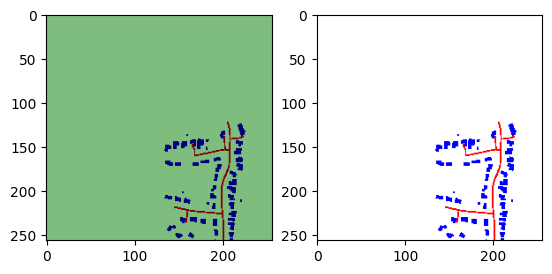

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Post procesisng because sometimes images come out skewed
def post_process_image(input_image, include_alpha=False):
    from sklearn.cluster import KMeans
    
    pixel_values = np.array(np.array(input_image).reshape((TILE_SIZE*TILE_SIZE,3 if not include_alpha else 4)))
    kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto') # n_init='auto' is the recommended setting
    
    kmeans.fit(pixel_values)
    labels = kmeans.predict(pixel_values)
    
    PURE_RED = np.array([[255,0,0]]) if not include_alpha else np.array([[255,0,0,255]])
    PURE_BLUE = np.array([[0,0,255]]) if not include_alpha else np.array([[0,0,255,255]])
    
    red_index = ((kmeans.cluster_centers_ - PURE_RED) ** 2).sum(axis=-1).argmin()
    blue_index = ((kmeans.cluster_centers_ - PURE_BLUE) ** 2).sum(axis=-1).argmin()
    
    if red_index == blue_index:
        blue_index = np.argsort(((kmeans.cluster_centers_ - PURE_RED) ** 2).sum(axis=-1))[1]
    
    white_index = -1
    if (red_index == 0 or blue_index ==0) and (red_index == 1 or blue_index == 1):
        white_index = 2
    elif (red_index == 0 or blue_index ==0) and (red_index == 2 or blue_index == 2):
        white_index = 1
    elif (red_index == 2 or blue_index ==2) and (red_index == 1 or blue_index == 1):
        white_index = 0
    else:
        printf("WTF")
    
    pixel_labels = labels.reshape(TILE_SIZE,TILE_SIZE)
    processed_img = np.zeros_like(input_image, dtype=np.uint8)
    processed_img[pixel_labels == white_index] = [255,255,255] if not include_alpha else [255,255,255,255]
    processed_img[pixel_labels == blue_index] = [0,0,255] if not include_alpha else [0,0,255,255]
    processed_img[pixel_labels == red_index] = [255,0,0] if not include_alpha else [255,0,0,255]

    return processed_img

fig,axs = plt.subplots(1,2)

img = np.array(Image.open(f"{TRAIN_DATASET_FOLDER}/data/train/tile_00000.png").convert('RGB'))
img = img // 2
img[:,:,1] = img[:,:,1] // 2 * 3
axs[0].imshow(img)
axs[1].imshow(post_process_image(img, include_alpha=False))

In [51]:
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

In [ ]:
from datasets import load_dataset

data_dir = f"{TRAIN_DATASET_FOLDER}/data/train"
printf(f"Loading dataset from {data_dir}")
dataset = load_dataset("imagefolder", data_dir=data_dir, split="train")

Resolving data files:   0%|          | 0/9108 [00:00<?, ?it/s]

In [53]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),                 # [0,1]
])

def preprocess(examples):
    examples["pixel_values"] = [transform(img.convert("RGB")) for img in examples["image"]]
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([ex["pixel_values"] for ex in examples])
    return {"pixel_values": pixel_values}

dataset = dataset.with_transform(preprocess)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet2DModel(
    sample_size=TILE_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=LAYERS_PER_BLOCK,
    block_out_channels=tuple(CHANNEL_COUNTS),  # stays small at high-res

    down_block_types=(
        DOWN_BLOCKS
    ),
    up_block_types=(
        UP_BLOCKS
    ),
).to(device)

printf(f'{sum(p.numel() for p in model.parameters()):,} Parameters')


noise_scheduler = DDPMScheduler(num_train_timesteps=NOISE_SCHEDULE_STEPS)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = EPOCHS * len(train_loader)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=total_steps
)

21,045,315 Parameters


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import L1Loss
import pandas as pd

model.train()
global_step = 0
loss_func = L1Loss()
loss_func = F.mse_loss

losses = []

os.makedirs(f"{RUN_FOLDER}/out", exist_ok=True)
os.makedirs(f"{RUN_FOLDER}/train_progress", exist_ok=True)

for epoch in range(EPOCHS):
    for batch in tqdm(train_loader):
        clean = batch["pixel_values"].to(device)  # (B,3,H,W)

        # Sample random timestep for each image
        bsz = clean.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device
        ).long()

        # Add noise
        noise = torch.randn_like(clean)
        noisy = noise_scheduler.add_noise(clean, noise, timesteps)

        # Predict noise
        noise_pred = model(noisy, timesteps).sample

        loss = loss_func(noise_pred, noise)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        losses.append(loss.item())

        LOSS_SMOOTHING = 20
        if global_step % 500 == 0:
            printf(f"epoch {epoch} step {global_step} loss {sum(losses[-LOSS_SMOOTHING:]) / len(losses[-LOSS_SMOOTHING:]):.4f}")
            images = DDPMPipeline(model, noise_scheduler)(batch_size=4, num_inference_steps=100, output_type="pil").images

            fig, axs = plt.subplots(2,2)
            fig.suptitle(f"epoch {epoch} step {global_step} loss {sum(losses[-LOSS_SMOOTHING:]) / len(losses[-LOSS_SMOOTHING:]):.4f}")
            axs[0,0].imshow(post_process_image(images[0]))
            axs[0,1].imshow(post_process_image(images[1]))
            axs[1,0].imshow(post_process_image(images[2]))
            axs[1,1].imshow(post_process_image(images[3]))

            fig.savefig(f"{RUN_FOLDER}/train_progress/{global_step}.png")
            plt.show()

            out_dir = f"{RUN_FOLDER}/out/city_diffusion_ddpm_{global_step}"
            os.makedirs(out_dir, exist_ok=True)
            
            pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
            pipe.save_pretrained(out_dir)

        if (global_step % 10) == 0:
            smoothed_losses = []
            for i in range(len(losses)):
                start_index = max(0, i - LOSS_SMOOTHING)
                smoothed_loss = sum(losses[start_index:i+1]) / (i - start_index + 1)
                smoothed_losses.append(smoothed_loss)

            steps = {'step': list(range(len(smoothed_losses))), 'loss': smoothed_losses}
            loss_df = pd.DataFrame(steps)
            loss_df.to_csv(f"{RUN_FOLDER}/loss_log.csv", index=False)
            
            
        global_step += 1